In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# Load the data
path = ('/content/Combined Data.csv')
df = pd.read_csv(path)

In [4]:
# Display the first few rows of the dataframe
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [5]:
# EDA
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [6]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [7]:
# Distribution of target labels
fig = px.histogram(df, x='status', title='Distribution of Mental Health Status')
fig.show()

In [8]:
# Handle NaN values in the statement column
df['statement'] = df['statement'].fillna('')

In [9]:
# Text Length Distribution
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

In [10]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [13]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df['statement'].apply(augment_text)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augmented_statement']
df = pd.concat([df, augmented_df])

In [14]:
# Reapply preprocessing on augmented data
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [15]:
# Ensure no NaN values are left
df['cleaned_statement'] = df['cleaned_statement'].fillna('')

In [16]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [19]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=100)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.11/dist-packages/sklearn/

In [20]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [21]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 10}
Accuracy Score:
0.7996983693090772
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.82      0.82      0.82      1562
             Bipolar       0.87      0.80      0.84      1150
          Depression       0.76      0.75      0.76      6182
              Normal       0.89      0.94      0.91      6571
Personality disorder       0.83      0.54      0.66       447
              Stress       0.69      0.60      0.64      1047
            Suicidal       0.71      0.71      0.71      4259

            accuracy                           0.80     21218
           macro avg       0.80      0.74      0.76     21218
        weighted avg       0.80      0.80      0.80     21218



In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

In [23]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()

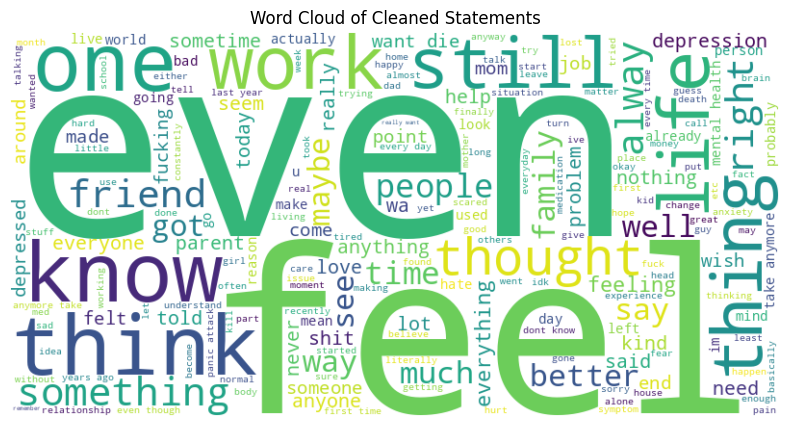

In [24]:

# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [25]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()

In [27]:
# Function to preprocess and predict mental health state
def predict_mental_health_state():
    # 1. Ask the user for input (you can replace this with your preferred method for input collection)
    new_data = input("Please describe your current mental state or any concerns you have: ")

    # 2. Preprocess the new data
    new_data_processed = preprocess_text(new_data)
    new_data_processed = remove_stopwords(new_data_processed)

    # 3. Vectorize the preprocessed data
    new_data_vectorized = vectorizer.transform([new_data_processed])

    # 4. Predict the mental health state
    prediction = best_model.predict(new_data_vectorized)

    # 5. Output the prediction
    print(f"The predicted mental health state is: {prediction[0]}")

# Run the prediction
predict_mental_health_state()

Please describe your current mental state or any concerns you have: i am overthinking i cant focus in my studies 
The predicted mental health state is: Normal
